# Deep Learning Project 1 - CIFAR-10 Image Classification and Analysis using ResNet

In [1]:
import os
import pickle
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.transforms import RandAugment
from torch.utils.data import DataLoader, random_split
from PIL import Image
from torchsummary import summary
from torch.optim import RAdam
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt


## Loading CIFAR-10 Dataset

In this section, we load the CIFAR-10 dataset from local storage, including:\
Loading metadata: Extracting class labels from the batches.meta file.\
Loading training data: Reading all five training batches and extracting image data and labels.\
Preprocessing the data: Reshaping and transposing the image data into the correct format (HWC: Height, Width, Channels).\

In [2]:
# Automatically select CPU or GPU for computation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Define CIFAR-10 dataset paths
cifar10_dir = './data/cifar-10-python/cifar-10-batches-py'
cifar_test_path = './data/cifar_test_nolabel.pkl'

# Function to load a CIFAR-10 batch from a file
def load_cifar_batch(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')  # Load batch using pickle
    return dict

# Load metadata (class labels)
meta_data_dict = load_cifar_batch(os.path.join(cifar10_dir, 'batches.meta'))
label_names = [label.decode('utf-8') for label in meta_data_dict[b'label_names']]  # Decode label names from bytes to string

# Load training data 
train_data = []
train_labels = []
for i in range(1, 6):
    batch = load_cifar_batch(os.path.join(cifar10_dir, f'data_batch_{i}'))  # Load batch
    train_data.append(batch[b'data'])  # Extract image data
    train_labels += batch[b'labels']  # Extract corresponding labels

# Preprocess training data
train_data = np.vstack(train_data).reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
# Convert training labels to a NumPy array
train_labels = np.array(train_labels)


Using device: cuda


Then, applying different data augmentation techniques to the training images, and visualizing the effects for comparing to select the appropriate method

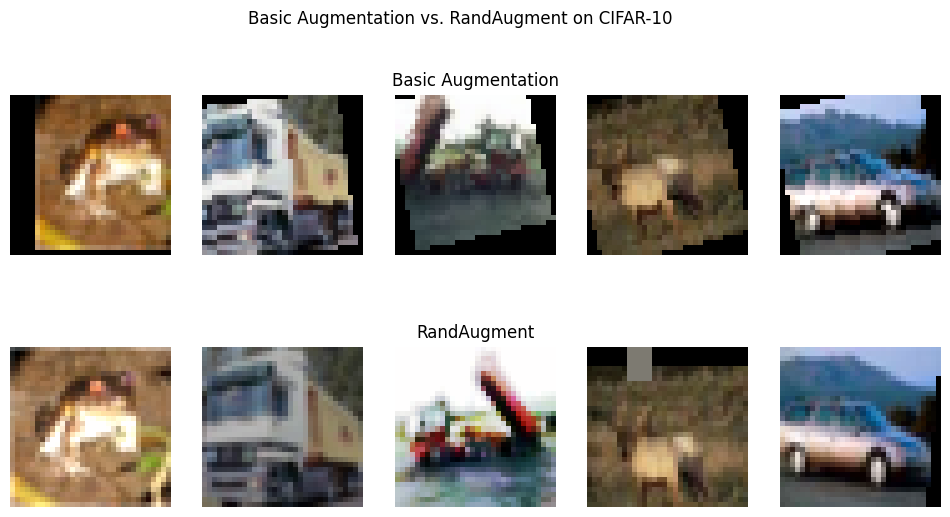

In [39]:
# Sample 5 random images from training data for visualization
sample_images = train_data[:5] 
sample_images = [Image.fromarray(img) for img in sample_images]

# Define first set of transformations (Basic Augmentation)
train_transform_basic = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
    transforms.RandomErasing(p=0.1, scale=(0.02, 0.08), value=0)
])

# Define RandAugment transformation
train_transform_randaug = transforms.Compose([
    RandAugment(),  # Automatically selects transformations
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
    transforms.RandomErasing(p=0.1, scale=(0.02, 0.08), value=0)
])

# Plot
fig, axes = plt.subplots(2, 5, figsize=(12, 6))  

for i in range(5):
    img = sample_images[i] 

    # Apply Basic Augmentation
    img_basic = train_transform_basic(img)
    img_basic = img_basic.permute(1, 2, 0).numpy() 
    img_basic = (img_basic * np.array([0.247, 0.243, 0.261])) + np.array([0.4914, 0.4822, 0.4465]) 
    img_basic = np.clip(img_basic, 0, 1)
    
    # Apply RandAugment
    img_randaug = train_transform_randaug(img)
    img_randaug = img_randaug.permute(1, 2, 0).numpy() 
    img_randaug = (img_randaug * np.array([0.247, 0.243, 0.261])) + np.array([0.4914, 0.4822, 0.4465])
    img_randaug = np.clip(img_randaug, 0, 1)

    # Display Basic Augmentation (Top Row)
    axes[0, i].imshow(img_basic)
    axes[0, i].axis("off")
    if i == 2:
        axes[0, i].set_title("Basic Augmentation") 

    # Display RandAugment (Bottom Row)
    axes[1, i].imshow(img_randaug)
    axes[1, i].axis("off")
    if i == 2:
        axes[1, i].set_title("RandAugment")  

plt.suptitle("Basic Augmentation vs. RandAugment on CIFAR-10") 
plt.show() 


Based on plots, RandAugment was applied to the training data, prepares the dataset for model training, and creates data loaders.

In [40]:
# Define training data transformation using RandAugment (automatic data augmentation)
train_transform = transforms.Compose([
    transforms.ToPILImage(),  
    RandAugment(), 
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)), 
    transforms.RandomErasing(p=0.1, scale=(0.02, 0.08), value=0)
])

# Define test data transformation (without augmentation)
test_transform = transforms.Compose([
    transforms.ToPILImage(), 
    transforms.ToTensor(), 
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))  
])

# Construct the training dataset (apply RandAugment transformation)
train_dataset = [(train_transform(img), label) for img, label in zip(train_data, train_labels)]

# Split the dataset into training (90%) and validation (10%) sets
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Load the test dataset
test_batch = load_cifar_batch(cifar_test_path)
raw_data = test_batch[b'data'] 
test_images = raw_data.astype(np.uint8)  # Convert to uint8 format

# Apply test transformations to construct the test dataset
test_dataset = [test_transform(img) for img in test_images]

# Create DataLoaders for efficient batch processing
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)  # Training set
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=4)  # Validation set
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)  # Test set

## Model Training

### MixUp Data Augmentation

Applies MixUp to blend images and labels, improving model generalization.

In [41]:
# Define MixUp data augmentation function
def mixup_data(x, y, alpha=0.2):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

### Model Training

Train the model, apply MixUp during training, calculate losses, and evaluate validation accuracy.

In [43]:
# Define the training function
def train_model(model, train_loader, val_loader, epochs=150):
    # Use CrossEntropyLoss with label smoothing to improve generalization
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    # Use RAdam optimizer for better adaptive learning rate adjustment
    optimizer = RAdam(model.parameters(), lr=0.001, weight_decay=1e-4)
    # Adaptive adjustment of learning rate
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10, verbose=True)  
    
    train_losses = []
    val_losses = []
    val_accuracies = []
            
    # Training loop
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0  
        # Iterate over batches in the training set
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()  # Reset gradients

            # Apply MixUp data augmentation
            images, targets_a, targets_b, lam = mixup_data(images, labels, alpha=0.2)
            # Forward pass
            outputs = model(images)
            # Compute MixUp loss as a weighted sum of two labels
            loss = lam * criterion(outputs, targets_a) + (1 - lam) * criterion(outputs, targets_b)
            
            # Backpropagation
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        # Compute average training loss for this epoch
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        # Validation phase (no MixUp applied)
        model.eval() 
        correct = 0
        total = 0
        val_loss = 0.0  

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)  
                
                # Forward pass on validation set
                outputs = model(images)
                
                # Compute validation loss
                loss = criterion(outputs, labels)  
                val_loss += loss.item()

                # Compute accuracy
                _, predicted = torch.max(outputs, 1) 
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        # Compute validation accuracy and average validation loss
        val_acc = 100 * correct / total  
        val_loss /= len(val_loader)  
        
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        # Adjust learning rate based on validation accuracy
        scheduler.step(val_acc)  

        # Print training and validation metrics for this epoch
        print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}, ' +
              f'Validation Accuracy: {val_acc:.2f}%, Validation Loss: {val_loss:.4f}')
        
    return train_losses, val_losses, val_accuracies

### Training Curve Visualization

Visualize training losses, validation losses, and validation accuracy trends.

In [44]:
# Function to plot training and validation curves
def plot_training_curves(train_losses, val_losses, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5)) 
    
    # Plot training and validation loss
    plt.subplot(1, 2, 1)  
    plt.plot(epochs, train_losses, label='Train Loss', color='blue') 
    plt.plot(epochs, val_losses, label='Validation Loss', color='red') 
    plt.xlabel('Epochs') 
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')  
    plt.legend()  
    
    # Plot validation accuracy
    plt.subplot(1, 2, 2) 
    plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)') 
    plt.title('Validation Accuracy') 
    plt.legend()

    plt.show() 

### Residual Block and ResNet Architecture

Define the model architecture, including residual blocks for deep feature learning.

In [45]:
# Define Residual Block module
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        
        # First convolutional layer in the residual block
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        
        # Second convolutional layer in the residual block
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # Skip connection: Used if input and output dimensions do not match
        self.skip = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.skip = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                          stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
            
        # Dropout to reduce overfitting
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        identity = x
        if self.skip:
            identity = self.skip(x)  # Adjust dimensions
        # Forward pass through the two convolutional layers
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        # Skip connection
        out += identity
        out = self.relu(out)
        out = self.dropout(out)
        return out

# Define Custom ResNet model
class CustomResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(CustomResNet, self).__init__()
        # Initial convolutional layer
        self.init_conv = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.init_bn = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)
        # Stack multiple residual blocks to build a deeper network
        self.layer1 = nn.Sequential(
            ResidualBlock(32, 64, stride=1),
            ResidualBlock(64, 64, stride=1)
        )
        self.layer2 = nn.Sequential(
            ResidualBlock(64, 128, stride=2),
            ResidualBlock(128, 128, stride=1)
        )
        self.layer3 = nn.Sequential(
            ResidualBlock(128, 256, stride=2),
            ResidualBlock(256, 256, stride=1)
        )
        # Global average pooling layer
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        # Fully connected layer
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        out = self.relu(self.init_bn(self.init_conv(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)   # Output Layer (Classification)
        return out


### Model Evaluation

Evaluate the performance of the model on a validation dataset.

In [46]:
# Function to evaluate the model's performance 
def evaluate_model(model, dataloader, dataset_name="Dataset"):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    # Compute final accuracy
    accuracy = 100 * correct / total
    print(f'Final {dataset_name} Accuracy: {accuracy:.2f}%')
    return accuracy

### Training Results and Final Evaluation

Train the model, plot the training results, and evaluate the final accuracy.

In [ ]:
# Train the model and plot training curves
model = CustomResNet().to(device)

# Print model architecture and number of parameters
summary(model, (3, 32, 32))

# Train the model
train_losses, val_losses, val_accuracies = train_model(model, train_loader, val_loader, epochs=150)

# Plot training loss and validation accuracy curves
plot_training_curves(train_losses, val_losses, val_accuracies)

# Compute and print final validation accuracy
final_val_accuracy = evaluate_model(model, val_loader, "Validation Set")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]           2,048
       BatchNorm2d-5           [-1, 64, 32, 32]             128
            Conv2d-6           [-1, 64, 32, 32]          18,432
       BatchNorm2d-7           [-1, 64, 32, 32]             128
              ReLU-8           [-1, 64, 32, 32]               0
            Conv2d-9           [-1, 64, 32, 32]          36,864
      BatchNorm2d-10           [-1, 64, 32, 32]             128
             ReLU-11           [-1, 64, 32, 32]               0
          Dropout-12           [-1, 64, 32, 32]               0
    ResidualBlock-13           [-1, 64, 32, 32]               0
           Conv2d-14           [-1, 64,

/home/yw8041/.local/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1, Loss: 1.9415, Validation Accuracy: 43.58%, Validation Loss: 1.7012
Epoch 2, Loss: 1.6622, Validation Accuracy: 60.44%, Validation Loss: 1.3930
Epoch 3, Loss: 1.5262, Validation Accuracy: 61.20%, Validation Loss: 1.3801
Epoch 4, Loss: 1.4469, Validation Accuracy: 66.98%, Validation Loss: 1.2467
Epoch 5, Loss: 1.3999, Validation Accuracy: 65.68%, Validation Loss: 1.2734
Epoch 6, Loss: 1.3379, Validation Accuracy: 71.32%, Validation Loss: 1.1602
Epoch 7, Loss: 1.3333, Validation Accuracy: 73.22%, Validation Loss: 1.1265
Epoch 8, Loss: 1.2584, Validation Accuracy: 71.26%, Validation Loss: 1.1653
Epoch 9, Loss: 1.2526, Validation Accuracy: 75.42%, Validation Loss: 1.0869
Epoch 10, Loss: 1.2757, Validation Accuracy: 77.34%, Validation Loss: 1.0411
Epoch 11, Loss: 1.1959, Validation Accuracy: 78.98%, Validation Loss: 0.9952
Epoch 12, Loss: 1.2415, Validation Accuracy: 79.02%, Validation Loss: 0.9986
Epoch 13, Loss: 1.1921, Validation Accuracy: 76.92%, Validation Loss: 1.0435
Epoch 14